# Homework 2
### Alex Simonoff

Prof. Cho - DS-GA 1011 | Natural Language Processing with Representation Learning

Much of the code and structure is from Lab 4

Help was given by TAs in office hours

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import csv
import pandas as pd
import matplotlib.pyplot as plt

random.seed(328)

PAD_IDX = 0
UNK_IDX = 1
BATCH_SIZE = 32

In [3]:
snli_train = pd.read_table('../hw2_data/snli_train.tsv')
snli_val = pd.read_table('../hw2_data/snli_val.tsv')
mnli_train = pd.read_table('../hw2_data/mnli_train.tsv')
mnli_val = pd.read_table('../hw2_data/mnli_val.tsv')

In [4]:
print("SNLI Training Examples: "+str(len(snli_train)))
print("SNLI Validation Examples: "+str(len(snli_val)))
print("MNLI Training Examples: "+str(len(mnli_train)))
print("MNLI Validation Examples: "+str(len(mnli_val)))

SNLI Training Examples: 100000
SNLI Validation Examples: 1000
MNLI Training Examples: 20000
MNLI Validation Examples: 5000


In [5]:
# shuffle to pull a random sample for testing
mnli_train = mnli_train.sample(frac=1).reset_index(drop=True)
snli_train = snli_train.sample(frac=1).reset_index(drop=True)

snli_test = snli_train[:20000]
mnli_test = mnli_train[:4000]
snli_train = snli_train[20000:].reset_index(drop=True)
mnli_train = mnli_train[4000:].reset_index(drop=True)

In [6]:
print("SNLI Training Examples: "+str(len(snli_train)))
print("SNLI Testing Examples: "+str(len(snli_test)))
print("SNLI Validation Examples: "+str(len(snli_val)))
print("MNLI Training Examples: "+str(len(mnli_train)))
print("MNLI Testing Examples: "+str(len(mnli_test)))
print("MNLI Validation Examples: "+str(len(mnli_val)))

SNLI Training Examples: 80000
SNLI Testing Examples: 20000
SNLI Validation Examples: 1000
MNLI Training Examples: 16000
MNLI Testing Examples: 4000
MNLI Validation Examples: 5000


In [7]:
# Loading word embeddings

# ADD TO HW LATEX REPORT
# @inproceedings{mikolov2018advances,
#   title={Advances in Pre-Training Distributed Word Representations},
#   author={Mikolov, Tomas and Grave, Edouard and Bojanowski, Piotr and Puhrsch, Christian and Joulin, Armand},
#   booktitle={Proceedings of the International Conference on Language Resources and Evaluation (LREC 2018)},
#   year={2018}
# }

import io
words_to_load = 50000

with open('../wiki-news-300d-1M.vec') as f:
    loaded_embeddings = np.zeros((words_to_load+2, 300))
    token2id = {}
    id2token = {}
    ordered_words = []
    for i, line in enumerate(f):
        if i > 0:
            if i >= words_to_load: 
                break
            s = line.split()
            loaded_embeddings[i+1, :] = np.asarray(s[1:])
            token2id[s[0]] = i+1
            id2token[i+1] = s[0]
            ordered_words.append(s[0])

loaded_embeddings[0] = np.zeros(300,)
loaded_embeddings[1] = np.random.rand(300,)
token2id['PAD']=0
token2id['UNK']=1
id2token[0]='PAD'
id2token[1]='UNK'
ordered_words = ['PAD', 'UNK'] + ordered_words

In [8]:
def encoding_label(x):
    if x == 'contradiction':
        return 0
    if x == 'neutral':
        return 1
    if x == 'entailment':
        return 2
    
def tokenize(sentence):
    tokens = [token2id[token] if token in token2id else UNK_IDX for token in sentence]
    return tokens

def tokenize_dataset(dataset):
    sentence_1 = [tokenize(tokens.split()) for tokens in dataset['sentence1'].tolist()] 
    sentence_2 = [tokenize(tokens.split()) for tokens in dataset['sentence2'].tolist()] 
    labels = [encoding_label(label) for label in dataset['label'].tolist()] 
    return sentence_1, sentence_2, labels

In [9]:
snli_train_sentence_1, snli_train_sentence_2, snli_train_label = tokenize_dataset(snli_train)
snli_val_sentence_1, snli_val_sentence_2, snli_val_label = tokenize_dataset(snli_val)
snli_test_sentence_1, snli_test_sentence_2, snli_test_label = tokenize_dataset(snli_test)

In [10]:
print(snli_train.iloc[0][0])
print(snli_train.iloc[0][1])
print(snli_train.iloc[0][2])

A teacher teaches a class of children .
A teacher is instructing children .
entailment


In [11]:
print(snli_train_sentence_1[0])
print(snli_train_sentence_2[0])
print(snli_train_label[0])

[106, 1833, 8656, 9, 539, 6, 249, 4]
[106, 1833, 15, 26350, 249, 4]
2


### PyTorch DataLoader

In [12]:
MAX_SAMPLE_LENGTH = max([len(word) for word in snli_train_sentence_1+snli_train_sentence_2])

class SentenceDataset(Dataset):
    def __init__(self, data1, data2, target_list, token2id):
        self.data1=data1
        self.data2=data2
        self.target_list=target_list
        assert (len(self.data1) == len(self.target_list))
        assert (len(self.data1) == len(self.data2))
        assert (len(self.data2) == len(self.target_list))
        self.token2id = token2id

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        token_idx1 = self.data1[key][:MAX_SAMPLE_LENGTH]
        token_idx2 = self.data2[key][:MAX_SAMPLE_LENGTH]
        label = self.target_list[key]
        return [token_idx1, token_idx2, len(token_idx1), len(token_idx2), label]

def sentence_collate_func(batch):
    data1_list = []
    data2_list = []
    label_list = []
    length1_list = []
    length2_list = []
    for datum in batch:
        label_list.append(datum[4])
        length1_list.append(datum[2])
        length2_list.append(datum[3])
    for datum in batch:
        padded_vec1 = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SAMPLE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        padded_vec2 = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SAMPLE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        data1_list.append(np.array(padded_vec1))
        data2_list.append(np.array(padded_vec2))
    data1_list = np.stack(data1_list)
    data2_list = np.stack(data2_list)
    length1_list = np.array(length1_list)
    length2_list = np.array(length2_list)
    label_list = np.array(label_list)
    return [torch.from_numpy(data1_list).float(), torch.from_numpy(data2_list).float(), torch.LongTensor(length1_list), torch.LongTensor(length2_list), torch.LongTensor(label_list)]

# create pytorch dataloader
train_dataset = SentenceDataset(snli_train_sentence_1, snli_train_sentence_2, snli_train_label, token2id)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           abatch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

val_dataset = SentenceDataset(snli_val_sentence_1, snli_val_sentence_2, snli_val_label, token2id)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

test_dataset = SentenceDataset(snli_test_sentence_1, snli_test_sentence_2, snli_test_label, token2id)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=False)

quarter_train_dataset = SentenceDataset(snli_train_sentence_1[:20000], snli_train_sentence_2[:20000], snli_train_label[:20000], token2id)
quarter_train_loader = torch.utils.data.DataLoader(dataset=quarter_train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

## RNN Model

In [13]:
class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings), freeze=True)
        self.rnn = nn.GRU(emb_size, self.hidden_size, self.num_layers, bidirectional=True, batch_first=True)
        
        self.fc1 = nn.Linear(4*self.hidden_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, num_classes)

    def init_hidden(self, batch_size):
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)
        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        batch_size, seq_len = x1.size()

        x1_lengths_sorted, ordered_idx1 = torch.sort(x1_lengths, dim=0, descending=True)
        x2_lengths_sorted, ordered_idx2 = torch.sort(x2_lengths, dim=0, descending=True)
        
        _, sorted_idx1 = ordered_idx1.sort(0)
        _, sorted_idx2 = ordered_idx2.sort(0)
        
        x1 = x1[ordered_idx1]
        x2 = x2[ordered_idx2]
        
        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)
        
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, x1_lengths_sorted, batch_first=True)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, x2_lengths_sorted, batch_first=True)
        
        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)
        
        _, self.hidden1 = self.rnn(embed1, self.hidden1)
        _, self.hidden2 = self.rnn(embed2, self.hidden2)
        
        rnn1_output = torch.cat((self.hidden1[0], self.hidden1[1]), dim = 1)[sorted_idx1]
        rnn2_output = torch.cat((self.hidden2[0], self.hidden2[1]), dim = 1)[sorted_idx2]

        concatenated = torch.cat([rnn1_output, rnn2_output], dim=1)
        output = F.relu(self.fc1(concatenated))
        logits = self.fc2(output) 

        return logits

In [14]:
def test_model(loader, model):
    correct = 0
    total = 0
    model.eval()
    for data, data2, lengths, lengths2, labels in loader:
        outputs = F.softmax(model(data.long(), data2.long(), lengths, lengths2), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [15]:
hidden_size_plotting=pd.DataFrame()
hidden_size_train_plotting=pd.DataFrame()

for k in [50, 100, 200]:
    model = RNN(emb_size=300, hidden_size=k, num_layers=1, num_classes=3)

    learning_rate = 3e-4
    num_epochs = 15

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_step = len(quarter_train_loader)
    val_accuracy = []
    train_accuracy = []
    for epoch in range(num_epochs):
        for i, (data1, data2, lengths, lengths2, labels) in enumerate(quarter_train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data1.long(), data2.long(), lengths, lengths2)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            if i > 0 and i % 250 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(quarter_train_loader, model)
                val_accuracy.append(val_acc)
                train_accuracy.append(train_acc)
                print('Epoch: [{}/{}], Validation Acc: {}, Training Acc: {}'.format(
                           epoch+1, num_epochs, val_acc, train_acc))
    hidden_size_plotting[str(k)] = pd.Series(val_accuracy)
    hidden_size_train_plotting[str(k)] = pd.Series(train_accuracy)

Epoch: [1/15], Validation Acc: 44.5, Training Acc: 45.21
Epoch: [1/15], Validation Acc: 50.5, Training Acc: 52.495
Epoch: [2/15], Validation Acc: 54.5, Training Acc: 55.555
Epoch: [2/15], Validation Acc: 57.7, Training Acc: 57.465
Epoch: [3/15], Validation Acc: 55.4, Training Acc: 58.505
Epoch: [3/15], Validation Acc: 58.2, Training Acc: 59.35
Epoch: [4/15], Validation Acc: 58.0, Training Acc: 60.23
Epoch: [4/15], Validation Acc: 58.6, Training Acc: 60.82
Epoch: [5/15], Validation Acc: 59.5, Training Acc: 61.305
Epoch: [5/15], Validation Acc: 59.3, Training Acc: 61.575
Epoch: [6/15], Validation Acc: 60.0, Training Acc: 62.47
Epoch: [6/15], Validation Acc: 59.7, Training Acc: 62.785
Epoch: [7/15], Validation Acc: 59.1, Training Acc: 62.2
Epoch: [7/15], Validation Acc: 59.7, Training Acc: 63.845
Epoch: [8/15], Validation Acc: 58.2, Training Acc: 63.5
Epoch: [8/15], Validation Acc: 59.9, Training Acc: 64.695
Epoch: [9/15], Validation Acc: 60.6, Training Acc: 65.02
Epoch: [9/15], Validatio

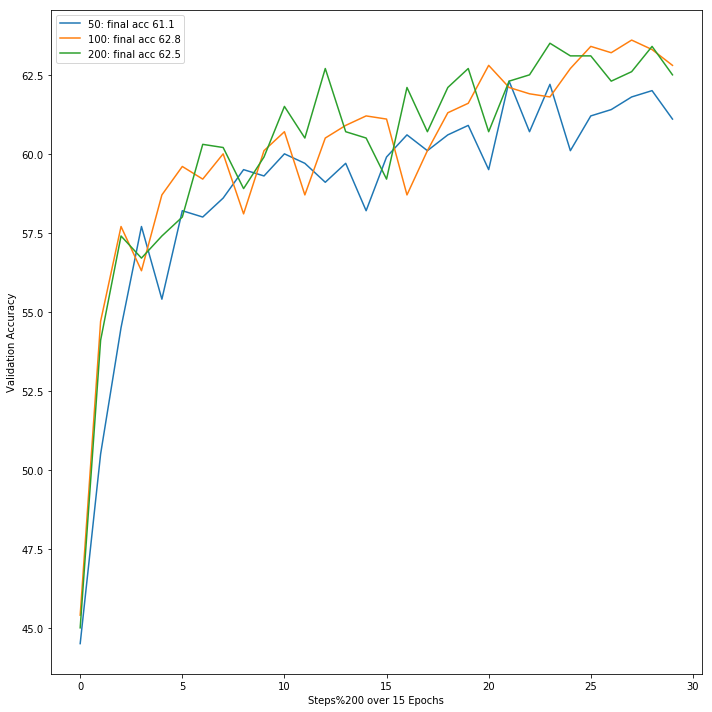

In [65]:
hidden_results = []
hidden_sizes = [50, 100, 200]
for i in range(3):
    value = list(hidden_size_plotting.iloc[-1])[i]
    value = str(hidden_sizes[i])+": final acc "+str(value)
    hidden_results.append(value)
    fig = plt.figure(figsize = (10,10))

plt.plot(hidden_size_plotting)
plt.xlabel("Steps%200 over 15 Epochs")
plt.ylabel("Validation Accuracy")
plt.legend(hidden_results, loc='best')
plt.tight_layout()
plt.savefig('hidden_size_rnn.png', dpi=300)
plt.show()

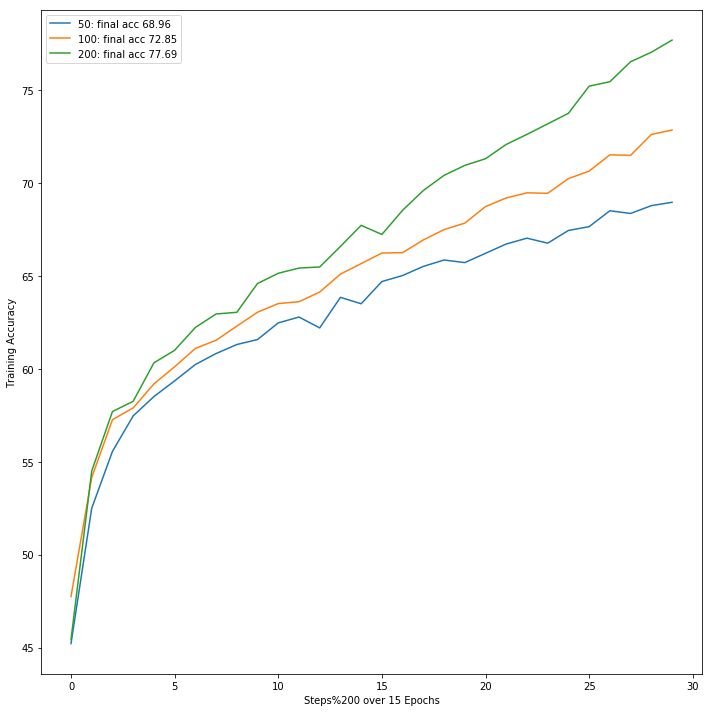

In [66]:
hidden_train_results = []
hidden_sizes = [50, 100, 200]
for i in range(3):
    value = list(hidden_size_train_plotting.iloc[-1])[i]
    value = str(hidden_sizes[i])+": final acc "+str(value)
    hidden_train_results.append(value)    
    
fig = plt.figure(figsize = (10,10))

plt.plot(hidden_size_train_plotting)
plt.xlabel("Steps%200 over 15 Epochs")
plt.ylabel("Training Accuracy")
plt.legend(hidden_train_results, loc='best')
plt.tight_layout()
plt.savefig('hidden_size_rnn_train.png', dpi=300)
plt.show()

## CNN Model

In [18]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, drop_rate=0, kernel_size=3):
        super(CNN, self).__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(loaded_embeddings), freeze=True)

        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=1)
        
        self.fc1 = nn.Linear(2*hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
        self.dropout = nn.Dropout(p=drop_rate)

    def init_hidden(self, batch_size):
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)
        return hidden

    def forward(self, x1, x2, x1_lengths, x2_lengths):
        batch_size, seq_len = x1.size()

        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)

        embed1 = self.embedding(x1)
        embed2 = self.embedding(x2)

        self.hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        self.hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        
        self.hidden1 = self.dropout(self.hidden1)
        self.hidden2 = self.dropout(self.hidden2)
        
        self.hidden1 = F.relu(self.hidden1.contiguous().view(-1, self.hidden1.size(-1))).view(batch_size, seq_len, self.hidden1.size(-1))
        self.hidden2 = F.relu(self.hidden2.contiguous().view(-1, self.hidden2.size(-1))).view(batch_size, seq_len, self.hidden2.size(-1))

        self.hidden1 = self.conv2(self.hidden1.transpose(1,2)).transpose(1,2)
        self.hidden2 = self.conv2(self.hidden2.transpose(1,2)).transpose(1,2)
        
        self.hidden1 = self.dropout(self.hidden1)
        self.hidden2 = self.dropout(self.hidden2)

        self.hidden1 = F.relu(self.hidden1.contiguous().view(-1, self.hidden1.size(-1))).view(batch_size, seq_len, self.hidden1.size(-1))
        self.hidden2 = F.relu(self.hidden2.contiguous().view(-1, self.hidden2.size(-1))).view(batch_size, seq_len, self.hidden2.size(-1))
        
        self.hidden1 = torch.sum(self.hidden1, dim=1)
        self.hidden2 = torch.sum(self.hidden2, dim=1)
        
        concatenated = torch.cat([self.hidden1, self.hidden2], dim=1)
        output = self.fc1(concatenated)
        output = F.relu(output)
        logits = self.fc2(output)
        return logits

In [49]:
dropout_plotting=pd.DataFrame()
dropout_train_plotting=pd.DataFrame()

for k in [0, .3, .5, .8]:
    model = CNN(emb_size=300, hidden_size=100, num_layers=2, num_classes=3, drop_rate = k)

    learning_rate = 3e-4
    num_epochs = 15

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_step = len(quarter_train_loader)
    val_accuracy = []
    train_accuracy = []
    for epoch in range(num_epochs):
        for i, (data1, data2, lengths, lengths2, labels) in enumerate(quarter_train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1.long(), data2.long(), lengths, lengths2)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            # validate every 200 iterations
            if i > 0 and i % 200 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(quarter_train_loader, model)
                val_accuracy.append(val_acc)
                train_accuracy.append(train_acc)
        print('Epoch: [{}/{}], Validation Acc: {}, Training Acc: {}'.format(
                           epoch+1, num_epochs, val_acc, train_acc))
    dropout_plotting[str(k)] = pd.Series(val_accuracy)
    dropout_train_plotting[str(k)] = pd.Series(train_accuracy)

Epoch: [1/15], Validation Acc: 58.3, Training Acc: 59.265
Epoch: [2/15], Validation Acc: 59.2, Training Acc: 63.39
Epoch: [3/15], Validation Acc: 59.7, Training Acc: 66.38
Epoch: [4/15], Validation Acc: 60.6, Training Acc: 69.385
Epoch: [5/15], Validation Acc: 60.8, Training Acc: 71.06
Epoch: [6/15], Validation Acc: 62.4, Training Acc: 75.78
Epoch: [7/15], Validation Acc: 62.6, Training Acc: 78.67
Epoch: [8/15], Validation Acc: 60.9, Training Acc: 81.67
Epoch: [9/15], Validation Acc: 61.3, Training Acc: 83.98
Epoch: [10/15], Validation Acc: 60.3, Training Acc: 86.685
Epoch: [11/15], Validation Acc: 59.7, Training Acc: 88.035
Epoch: [12/15], Validation Acc: 60.3, Training Acc: 90.635
Epoch: [13/15], Validation Acc: 59.8, Training Acc: 92.115
Epoch: [14/15], Validation Acc: 59.0, Training Acc: 92.3
Epoch: [15/15], Validation Acc: 58.2, Training Acc: 93.945
Epoch: [1/15], Validation Acc: 55.4, Training Acc: 57.945
Epoch: [2/15], Validation Acc: 56.6, Training Acc: 59.68
Epoch: [3/15], Val

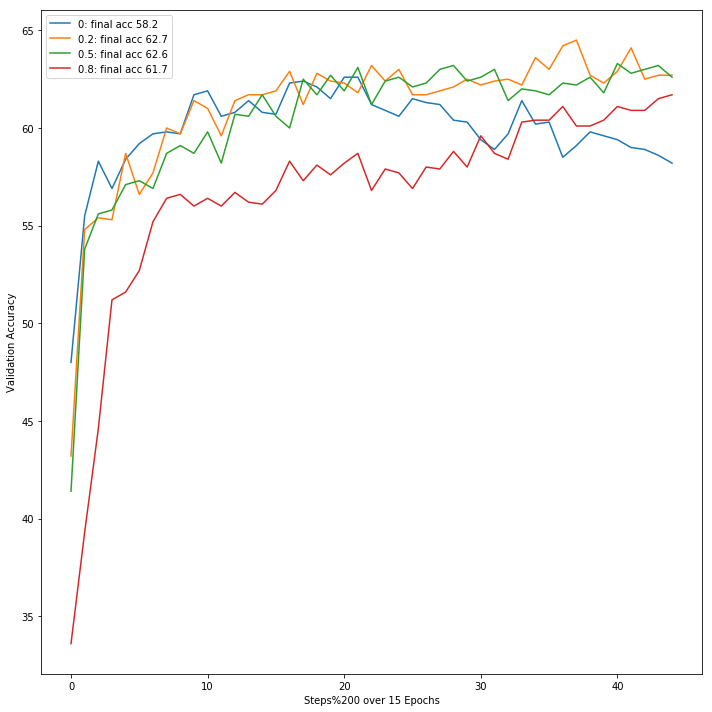

In [67]:
drop_results = []
drop_rate = [0, .2, .5, .8]
for i in range(4):
    value = list(dropout_plotting.iloc[-1])[i]
    value = str(drop_rate[i])+": final acc "+str(value)
    drop_results.append(value)    
    
fig = plt.figure(figsize = (10,10))

plt.plot(dropout_plotting)
plt.xlabel("Steps%200 over 15 Epochs")
plt.ylabel("Validation Accuracy")
plt.legend(drop_results, loc='best')
plt.tight_layout()
plt.savefig('drop_rate.png', dpi=300)
plt.show()

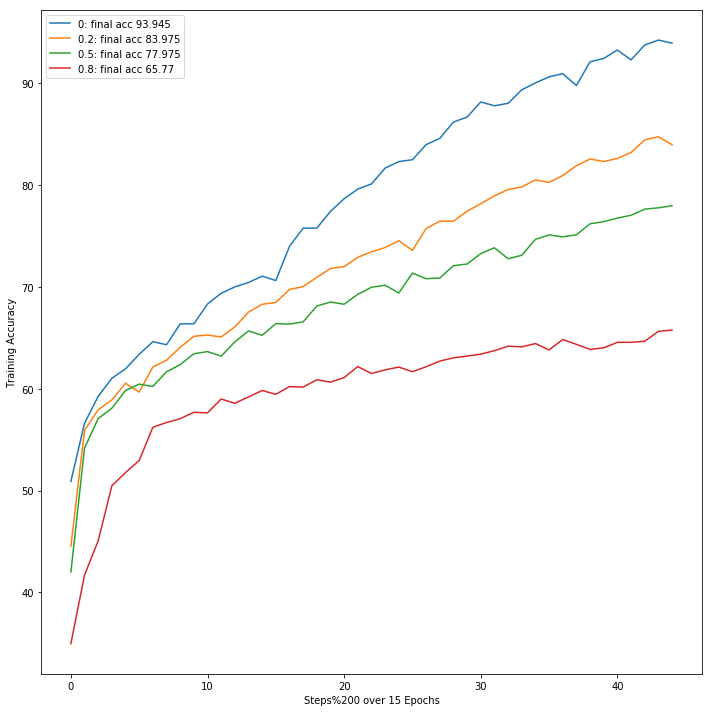

In [68]:
drop_results_train = []
drop_rate = [0, .2, .5, .8]
for i in range(4):
    value = list(dropout_train_plotting.iloc[-1])[i]
    value = str(drop_rate[i])+": final acc "+str(value)
    drop_results_train.append(value)    

fig = plt.figure(figsize = (10,10))

plt.plot(dropout_train_plotting)
plt.xlabel("Steps%200 over 15 Epochs")
plt.ylabel("Training Accuracy")
plt.legend(drop_results_train, loc='best')
plt.tight_layout()
plt.savefig('drop_rate_train.png', dpi=300)
plt.show()

In [54]:
cnn_hidden_size_plotting=pd.DataFrame()
cnn_hidden_size_train_plotting=pd.DataFrame()

for k in [50, 100, 200]:
    model = CNN(emb_size=300, hidden_size=k, num_layers=2, num_classes=3, drop_rate=0.2)

    learning_rate = 3e-4
    num_epochs = 15

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    total_step = len(quarter_train_loader)
    val_accuracy = []
    train_accuracy = []
    for epoch in range(num_epochs):
        for i, (data1, data2, lengths, lengths2, labels) in enumerate(quarter_train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1.long(), data2.long(), lengths, lengths2)
            loss = criterion(outputs, labels)
            # Backward and optimize
            loss.backward()
            optimizer.step()
            if i > 0 and i % 200 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(quarter_train_loader, model)
                val_accuracy.append(val_acc)
                train_accuracy.append(train_acc)
        print('Epoch: [{}/{}], Validation Acc: {}, Training Acc: {}'.format(
                           epoch+1, num_epochs, val_acc, train_acc))
    cnn_hidden_size_plotting[str(k)] = pd.Series(val_accuracy)
    cnn_hidden_size_train_plotting[str(k)] = pd.Series(train_accuracy)

Epoch: [1/15], Validation Acc: 53.2, Training Acc: 54.765
Epoch: [2/15], Validation Acc: 57.5, Training Acc: 60.285
Epoch: [3/15], Validation Acc: 58.5, Training Acc: 61.105
Epoch: [4/15], Validation Acc: 58.5, Training Acc: 62.795
Epoch: [5/15], Validation Acc: 59.6, Training Acc: 64.44
Epoch: [6/15], Validation Acc: 60.3, Training Acc: 66.69
Epoch: [7/15], Validation Acc: 61.8, Training Acc: 68.105
Epoch: [8/15], Validation Acc: 60.1, Training Acc: 68.745
Epoch: [9/15], Validation Acc: 61.7, Training Acc: 70.725
Epoch: [10/15], Validation Acc: 60.7, Training Acc: 71.55
Epoch: [11/15], Validation Acc: 61.1, Training Acc: 72.51
Epoch: [12/15], Validation Acc: 60.6, Training Acc: 75.125
Epoch: [13/15], Validation Acc: 60.7, Training Acc: 75.695
Epoch: [14/15], Validation Acc: 62.5, Training Acc: 77.445
Epoch: [15/15], Validation Acc: 61.2, Training Acc: 78.87
Epoch: [1/15], Validation Acc: 56.0, Training Acc: 58.525
Epoch: [2/15], Validation Acc: 58.2, Training Acc: 61.745
Epoch: [3/15]

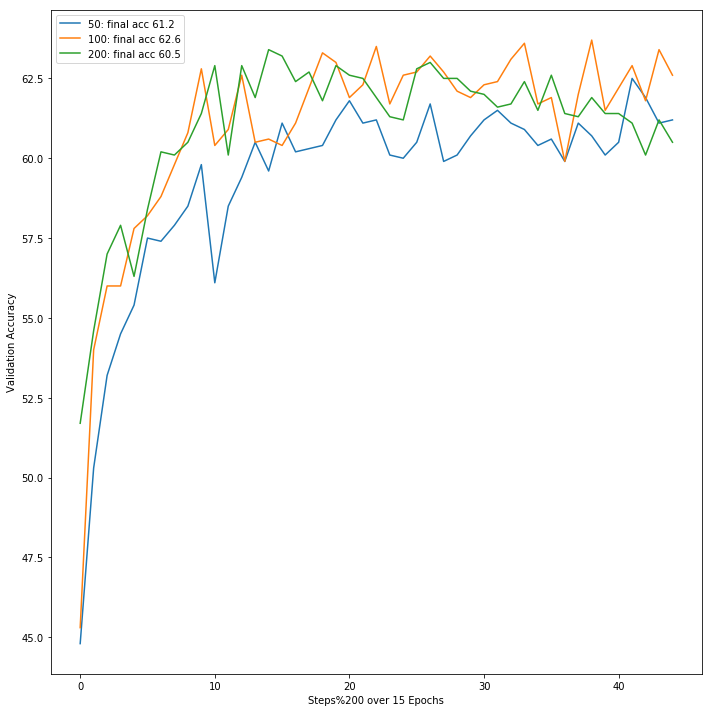

In [69]:
cnn_hidden_results = []
hidden_sizes = [50, 100, 200]
for i in range(3):
    value = list(cnn_hidden_size_plotting.iloc[-1])[i]
    value = str(hidden_sizes[i])+": final acc "+str(value)
    cnn_hidden_results.append(value)    

fig = plt.figure(figsize = (10,10))

plt.plot(cnn_hidden_size_plotting)
plt.xlabel("Steps%200 over 15 Epochs")
plt.ylabel("Validation Accuracy")
plt.legend(cnn_hidden_results, loc='best')
plt.tight_layout()
plt.savefig('hidden_size_cnn.png', dpi=300)
plt.show()

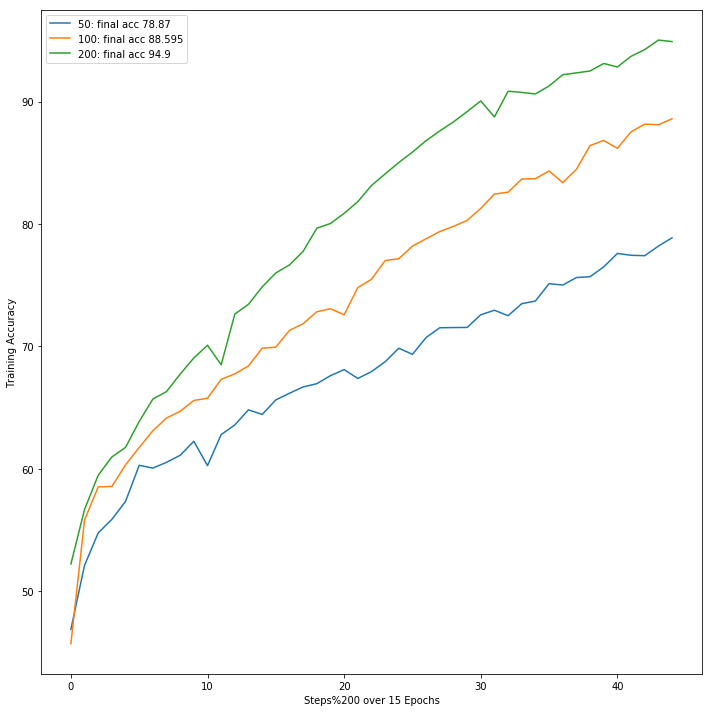

In [70]:
cnn_hidden_results_train = []
hidden_sizes = [50, 100, 200]
for i in range(3):
    value = list(cnn_hidden_size_train_plotting.iloc[-1])[i]
    value = str(hidden_sizes[i])+": final acc "+str(value)
    cnn_hidden_results_train.append(value)    

fig = plt.figure(figsize = (10,10))

plt.plot(cnn_hidden_size_train_plotting)
plt.xlabel("Steps%200 over 15 Epochs")
plt.ylabel("Training Accuracy")
plt.legend(cnn_hidden_results_train, loc='best')
plt.tight_layout()
plt.savefig('hidden_size_train_cnn.png', dpi=300)
plt.show()

## Best Model Full Test

In [63]:
best_model_plotting=pd.DataFrame()
best_model_train_plotting=pd.DataFrame()

model = CNN(emb_size=300, hidden_size=100, num_layers=2, num_classes=3, drop_rate=0.2)

learning_rate = 3e-4
num_epochs = 15

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)
val_accuracy = []
train_accuracy = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths, lengths2, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(data1.long(), data2.long(), lengths, lengths2)
        loss = criterion(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()
        if i > 0 and i % 250 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            train_acc = test_model(train_loader, model)
            val_accuracy.append(val_acc)
            train_accuracy.append(train_acc)
            print('Epoch: [{}/{}], Validation Acc: {}, Training Acc: {}'.format(
                       epoch+1, num_epochs, val_acc, train_acc))
best_model_plotting[str(k)] = pd.Series(val_accuracy)
best_model_train_plotting[str(k)] = pd.Series(train_accuracy)

Epoch: [1/15], Validation Acc: 42.8, Training Acc: 45.61375
Epoch: [1/15], Validation Acc: 55.4, Training Acc: 56.54875
Epoch: [1/15], Validation Acc: 55.8, Training Acc: 58.515
Epoch: [1/15], Validation Acc: 56.9, Training Acc: 59.39
Epoch: [1/15], Validation Acc: 58.5, Training Acc: 60.515
Epoch: [1/15], Validation Acc: 60.1, Training Acc: 61.525
Epoch: [1/15], Validation Acc: 60.2, Training Acc: 61.37125
Epoch: [1/15], Validation Acc: 60.3, Training Acc: 62.5175
Epoch: [1/15], Validation Acc: 61.7, Training Acc: 62.23875
Epoch: [2/15], Validation Acc: 62.1, Training Acc: 63.9775
Epoch: [2/15], Validation Acc: 62.5, Training Acc: 64.21
Epoch: [2/15], Validation Acc: 62.6, Training Acc: 63.61375
Epoch: [2/15], Validation Acc: 60.5, Training Acc: 63.0125
Epoch: [2/15], Validation Acc: 60.5, Training Acc: 64.7275
Epoch: [2/15], Validation Acc: 63.6, Training Acc: 65.3
Epoch: [2/15], Validation Acc: 62.4, Training Acc: 65.5975
Epoch: [2/15], Validation Acc: 63.4, Training Acc: 65.785
Epo

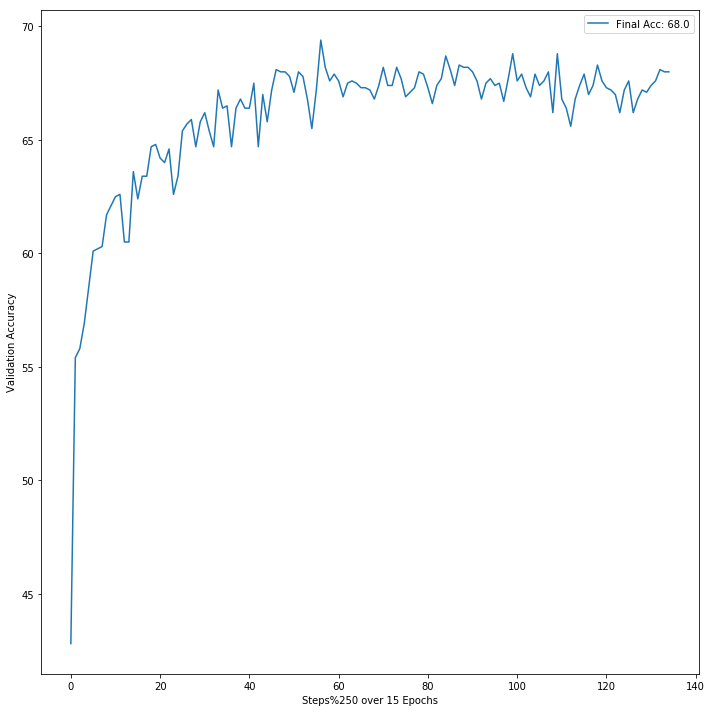

In [75]:
legend_val=["Final Acc: "+str(best_model_plotting.iloc[-1][0])]

fig = plt.figure(figsize = (10,10))

plt.plot(best_model_plotting)
plt.xlabel("Steps%250 over 15 Epochs")
plt.ylabel("Validation Accuracy")
plt.legend(legend_val, loc='best')
plt.tight_layout()
plt.savefig('best_model.png', dpi=300)
plt.show()

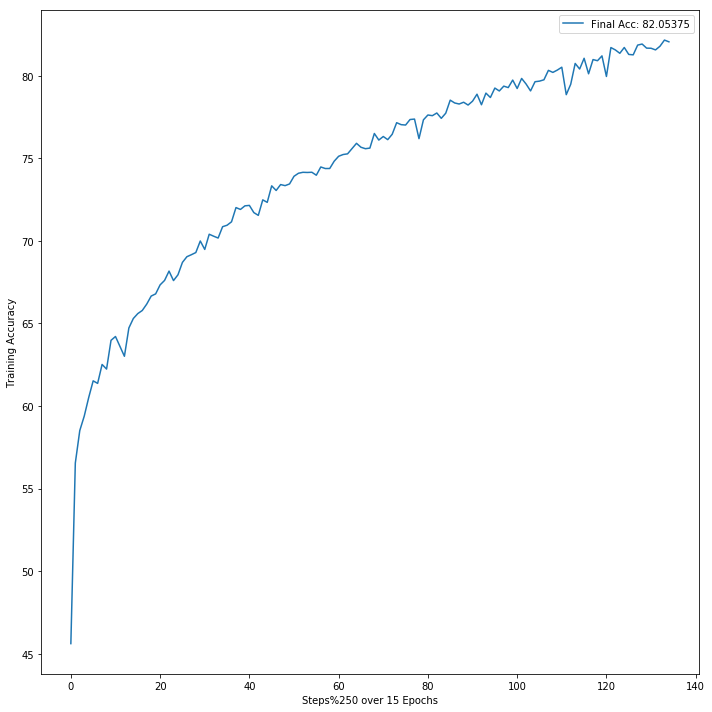

In [76]:
legend_val=["Final Acc: "+str(best_model_train_plotting.iloc[-1][0])]

fig = plt.figure(figsize = (10,10))
plt.plot(best_model_train_plotting)
plt.xlabel("Steps%250 over 15 Epochs")
plt.ylabel("Training Accuracy")
plt.legend(legend_val, loc='best')
plt.tight_layout()
plt.savefig('best_model_training.png', dpi=300)
plt.show()

In [73]:
print("test accuracy: ", test_model(test_loader, model))

test accuracy:  68.655


In [147]:
mini_val_dataset = SentenceDataset(snli_val_sentence_1[:10], snli_val_sentence_2[:10], snli_val_label[:10], token2id)
mini_val_loader = torch.utils.data.DataLoader(dataset=mini_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

model.eval()
for data, data2, lengths, lengths2, labels in mini_val_loader:
    outputs = F.softmax(model(data.long(), data2.long(), lengths, lengths2), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    predicted_label = [item for sublist in predicted.eq(labels.view_as(predicted)).numpy().tolist() for item in sublist]
    if j < 3:
        print("Sentence 1: ",' '.join(id2token[item] for item in snli_val_sentence_1[i]))
        print("Sentence 2: ",' '.join(id2token[item] for item in snli_val_sentence_2[i]))
        print("Label: ",snli_val_label[i])
        print("Predicted Label: ",predicted_label[i])

Sentence 1:  Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
Sentence 2:  There are two women standing on the stage
Label:  0
Predicted Label:  1
Sentence 1:  Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .
Sentence 2:  Multiple people are on a subway together , with each of them doing their own thing .
Label:  2
Predicted Label:  0
Sentence 1:  bicycles stationed while a group of people socialize .
Sentence 2:  People get together near a stand of bicycles .
Label:  2
Predicted Label:  1
Sentence 1:  Man in UNK with two horses .
Sentence 2:  a man in UNK with two horses
Label:  2
Predicted Label:  0
Sentence 1:  Man observes a wavelength given off by an electronic device .
Sentence 2:  The man is examining what wavelength is given off by

In [198]:
batch1_val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=1,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)
correct = 0
incorrect = 0
model.eval()
for data, data2, lengths, lengths2, labels in batch1_val_loader:
    outputs = F.softmax(model(data.long(), data2.long(), lengths, lengths2), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    if correct <=5:
        if torch.eq(predicted,labels).item() == 1:
            print('CORRECT EXAMPLE')
            print("Sentence 1: ",' '.join(id2token[item] for item in np.asarray(data)[0] if item!=0))
            print("Sentence 2: ",' '.join(id2token[item] for item in np.asarray(data2)[0] if item!=0))
            print("Label: ",labels.item())
            print("Predicted Label: ",predicted[0].item())
            print("\n")
            correct+=1
    if incorrect<=5:
        if torch.eq(predicted,labels).item() == 0:
            print('INCORRECT EXAMPLE')
            print("Sentence 1: ",' '.join(id2token[item] for item in np.asarray(data)[0] if item!=0))
            print("Sentence 2: ",' '.join(id2token[item] for item in np.asarray(data2)[0] if item!=0))
            print("Label: ",labels.item())
            print("Predicted Label: ",predicted[0].item())
            print("\n")
            incorrect+=1

CORRECT EXAMPLE
Sentence 1:  a lone UNK jumping through the air in front of a large crowd .
Sentence 2:  The man is wearing a helmet .
Label:  1
Predicted Label:  1


CORRECT EXAMPLE
Sentence 1:  A woman holding a red cup with a straw in it sits in front of a man and a woman looking at a book .
Sentence 2:  A woman sits .
Label:  2
Predicted Label:  2


CORRECT EXAMPLE
Sentence 1:  Several people prepare their stalls that consist of fish , vegetables and fruits for the public eye .
Sentence 2:  two men sit in a truck
Label:  0
Predicted Label:  0


INCORRECT EXAMPLE
Sentence 1:  A woman in a purple shirt buying food from a street vendor .
Sentence 2:  A woman makes a purchase from a vendor outside .
Label:  2
Predicted Label:  1


CORRECT EXAMPLE
Sentence 1:  A group of dancers with green shirts are all holding hands in a circle , one lady has a white shirt .
Sentence 2:  A group of dancers is about to dance for a school competition
Label:  1
Predicted Label:  1


INCORRECT EXAMPLE
Sen

## Testing model on MNLI

In [77]:
mnli_val.genre.value_counts()

government    1016
telephone     1005
slate         1002
fiction        995
travel         982
Name: genre, dtype: int64

In [78]:
mnli_gov_sentence_1, mnli_gov_sentence_2, mnli_gov_label = tokenize_dataset(mnli_val[mnli_val['genre']=='government'])
mnli_tele_sentence_1, mnli_tele_sentence_2, mnli_tele_label = tokenize_dataset(mnli_val[mnli_val['genre']=='telephone'])
mnli_slate_sentence_1, mnli_slate_sentence_2, mnli_slate_label = tokenize_dataset(mnli_val[mnli_val['genre']=='slate'])
mnli_fic_sentence_1, mnli_fic_sentence_2, mnli_fic_label = tokenize_dataset(mnli_val[mnli_val['genre']=='fiction'])
mnli_trav_sentence_1, mnli_trav_sentence_2, mnli_trav_label = tokenize_dataset(mnli_val[mnli_val['genre']=='travel'])

In [201]:
# genre loaders
gov_dataset = SentenceDataset(mnli_gov_sentence_1, mnli_gov_sentence_2, mnli_gov_label, token2id)
gov_loader = torch.utils.data.DataLoader(dataset=gov_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

tele_dataset = SentenceDataset(mnli_tele_sentence_1, mnli_tele_sentence_2, mnli_tele_label, token2id)
tele_loader = torch.utils.data.DataLoader(dataset=tele_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

slate_dataset = SentenceDataset(mnli_slate_sentence_1, mnli_slate_sentence_2, mnli_slate_label, token2id)
slate_loader = torch.utils.data.DataLoader(dataset=slate_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

fic_dataset = SentenceDataset(mnli_fic_sentence_1, mnli_fic_sentence_2, mnli_fic_label, token2id)
fic_loader = torch.utils.data.DataLoader(dataset=fic_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

trav_dataset = SentenceDataset(mnli_trav_sentence_1, mnli_trav_sentence_2, mnli_trav_label, token2id)
trav_loader = torch.utils.data.DataLoader(dataset=trav_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=sentence_collate_func,
                                           shuffle=True)

In [203]:
print("Validation accuracy for government: ",test_model(gov_loader, model))
print("Validation accuracy for telephone: ",test_model(tele_loader, model))
print("Validation accuracy for slate: ",test_model(slate_loader, model))
print("Validation accuracy for fiction: ",test_model(fic_loader, model))
print("Validation accuracy for travel: ",test_model(trav_loader, model))

Validation accuracy for government:  43.40551181102362
Validation accuracy for telephone:  42.885572139303484
Validation accuracy for slate:  41.01796407185629
Validation accuracy for fiction:  43.21608040201005
Validation accuracy for travel:  43.58452138492871


In [205]:
mnli_val.head(15)

,sentence1,sentence2,label,genre
0,"'Not entirely , ' I snapped , harsher than int...",I spoke more harshly than I wanted to .,entailment,fiction
1,cook and then the next time it would be my tur...,I would cook and then the next turn would be h...,contradiction,telephone
2,The disorder hardly seemed to exist before the...,The disorder did n't seem to be as common when...,entailment,slate
3,"The Report and Order , in large part , adopts ...",The Report and Order ignores recommendations f...,contradiction,government
4,"IDPA 's OIG 's mission is to prevent , detect ...",IDPA 's OIG 's mission is clear and cares abou...,entailment,government
5,"Because of limited resources , local legal ser...","If the resources were there , it would be unth...",neutral,government
6,"Generally , if pH of scrubbing liquor falls be...",if pH of scrubbing liquor becomes above a rang...,contradiction,government
7,"Nearby is the Monastery of Nea Moni , founded ...","Founded in 1049 , the monastery was a beacon o...",neutral,travel
8,"Prototyping , for example , may act as part of...",Prototyping is important .,neutral,government
9,The Leland Act ( 1 ) simplify the household de...,A household is a concept that can not be defin...,contradiction,government


In [206]:
rnn_model = RNN(emb_size=300, hidden_size=100, num_layers=1, num_classes=3)

learning_rate = 3e-4
num_epochs = 15

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)

total_step = len(train_loader)
val_accuracy = []
train_accuracy = []
for epoch in range(num_epochs):
    for i, (data1, data2, lengths, lengths2, labels) in enumerate(train_loader):
        rnn_model.train()
        optimizer.zero_grad()
        outputs = rnn_model(data1.long(), data2.long(), lengths, lengths2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if i > 0 and i % 250 == 0:
            val_acc = test_model(val_loader, rnn_model)
            train_acc = test_model(train_loader, rnn_model)
            val_accuracy.append(val_acc)
            train_accuracy.append(train_acc)
            print('Epoch: [{}/{}], Validation Acc: {}, Training Acc: {}'.format(
                       epoch+1, num_epochs, val_acc, train_acc))

Epoch: [1/15], Validation Acc: 45.7, Training Acc: 46.38875
Epoch: [1/15], Validation Acc: 53.3, Training Acc: 53.215
Epoch: [1/15], Validation Acc: 56.0, Training Acc: 54.8325
Epoch: [1/15], Validation Acc: 54.5, Training Acc: 56.02625
Epoch: [1/15], Validation Acc: 58.2, Training Acc: 57.5275
Epoch: [1/15], Validation Acc: 58.0, Training Acc: 58.02625
Epoch: [1/15], Validation Acc: 59.0, Training Acc: 58.1175
Epoch: [1/15], Validation Acc: 58.2, Training Acc: 59.2575
Epoch: [1/15], Validation Acc: 59.5, Training Acc: 59.69875
Epoch: [2/15], Validation Acc: 57.8, Training Acc: 59.6925
Epoch: [2/15], Validation Acc: 59.1, Training Acc: 60.58125
Epoch: [2/15], Validation Acc: 58.4, Training Acc: 61.0525
Epoch: [2/15], Validation Acc: 58.4, Training Acc: 61.115
Epoch: [2/15], Validation Acc: 59.5, Training Acc: 61.27375
Epoch: [2/15], Validation Acc: 59.5, Training Acc: 61.30875
Epoch: [2/15], Validation Acc: 61.1, Training Acc: 61.60875
Epoch: [2/15], Validation Acc: 60.8, Training Acc:

In [207]:
print("Validation accuracy for government: ",test_model(gov_loader, rnn_model))
print("Validation accuracy for telephone: ",test_model(tele_loader, rnn_model))
print("Validation accuracy for slate: ",test_model(slate_loader, rnn_model))
print("Validation accuracy for fiction: ",test_model(fic_loader, rnn_model))
print("Validation accuracy for travel: ",test_model(trav_loader, rnn_model))

Validation accuracy for government:  45.374015748031496
Validation accuracy for telephone:  45.57213930348259
Validation accuracy for slate:  44.61077844311377
Validation accuracy for fiction:  47.1356783919598
Validation accuracy for travel:  45.621181262729124


In [208]:
print("test accuracy: ", test_model(test_loader, rnn_model))

test accuracy:  70.085
